# Global Terrorism Database

## Introduction
The aim of this analysis is to provide answers to the following questions:

- How has the number of terrorist activities changed over the years?
- Are there certain regions where this trend is different from the global averages?
- How often the attack becomes a success?
- What are the most common methods of attacks? Does it differ in various regions or in time?

## About the dataset
The Dataset was extracted from the Global Terrorism Database (GTD) - an open-source database including information on terrorist attacks around the world from 1970 through 2017. The GTD includes systematic data on domestic as well as international terrorist incidents that have occurred during this time period and now includes more than 180,000 attacks.

## Explanation of selected columns:
- success - Success of a terrorist strike
- suicide - 1 = "Yes" The incident was a suicide attack. 0 = "No" There is no indication that the incident was a suicide
- attacktype1 - The general method of attack
- attacktype1_txt - The general method of attack and broad class of tactics used.
- targtype1_txt - The general type of target/victim
- targsubtype1_txt - The more specific target category
- target1 - The specific person, building, installation that was targeted and/or victimized
- natlty1_txt - The nationality of the target that was attacked
- gname - The name of the group that carried out the attack
- gsubname - Additional details about group that carried out the attack like fractions
- nperps - The total number of terrorists participating in the incident
- weaptype1_txt - General type of weapon used in the incident
- weapsubtype1_txt - More specific value for most of the Weapon Types
- nkill - The number of total confirmed fatalities for the incident
- nkillus - The number of U.S. citizens who died as a result of the incident

In [484]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, classification_report, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier

from sklearn.pipeline import make_pipeline

In [219]:
data = pd.read_csv('../globalterrorismdb_0718dist.csv', encoding='latin-1')

In [220]:
data.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


In [221]:
print('Number of Variables in dataset: ', data.shape[1])

Number of Variables in dataset:  135


In [222]:
print('Number of records in dataset: ', data.shape[0])

Number of records in dataset:  181691


In [223]:
data.columns.values

array(['eventid', 'iyear', 'imonth', 'iday', 'approxdate', 'extended',
       'resolution', 'country', 'country_txt', 'region', 'region_txt',
       'provstate', 'city', 'latitude', 'longitude', 'specificity',
       'vicinity', 'location', 'summary', 'crit1', 'crit2', 'crit3',
       'doubtterr', 'alternative', 'alternative_txt', 'multiple',
       'success', 'suicide', 'attacktype1', 'attacktype1_txt',
       'attacktype2', 'attacktype2_txt', 'attacktype3', 'attacktype3_txt',
       'targtype1', 'targtype1_txt', 'targsubtype1', 'targsubtype1_txt',
       'corp1', 'target1', 'natlty1', 'natlty1_txt', 'targtype2',
       'targtype2_txt', 'targsubtype2', 'targsubtype2_txt', 'corp2',
       'target2', 'natlty2', 'natlty2_txt', 'targtype3', 'targtype3_txt',
       'targsubtype3', 'targsubtype3_txt', 'corp3', 'target3', 'natlty3',
       'natlty3_txt', 'gname', 'gsubname', 'gname2', 'gsubname2',
       'gname3', 'gsubname3', 'motive', 'guncertain1', 'guncertain2',
       'guncertain3', 'in

In [224]:
data['attacktype1_txt'].value_counts()

attacktype1_txt
Bombing/Explosion                      88255
Armed Assault                          42669
Assassination                          19312
Hostage Taking (Kidnapping)            11158
Facility/Infrastructure Attack         10356
Unknown                                 7276
Unarmed Assault                         1015
Hostage Taking (Barricade Incident)      991
Hijacking                                659
Name: count, dtype: int64

In [225]:
data['attacktype2_txt'].value_counts()

attacktype2_txt
Armed Assault                          3434
Facility/Infrastructure Attack         1653
Bombing/Explosion                       506
Hostage Taking (Kidnapping)             479
Assassination                           162
Hostage Taking (Barricade Incident)      37
Unarmed Assault                          30
Hijacking                                10
Unknown                                   3
Name: count, dtype: int64

In [226]:
data['attacktype3_txt'].value_counts()

attacktype3_txt
Facility/Infrastructure Attack         229
Armed Assault                          119
Hostage Taking (Kidnapping)             53
Bombing/Explosion                       16
Hijacking                                4
Assassination                            4
Hostage Taking (Barricade Incident)      2
Unarmed Assault                          1
Name: count, dtype: int64

# Exploratory Data Analysis

### 1. Number of Terrorist Attacks per year

In [229]:
# Attacks per Year in whole world
attacks_per_year = data['iyear'].value_counts().sort_index()

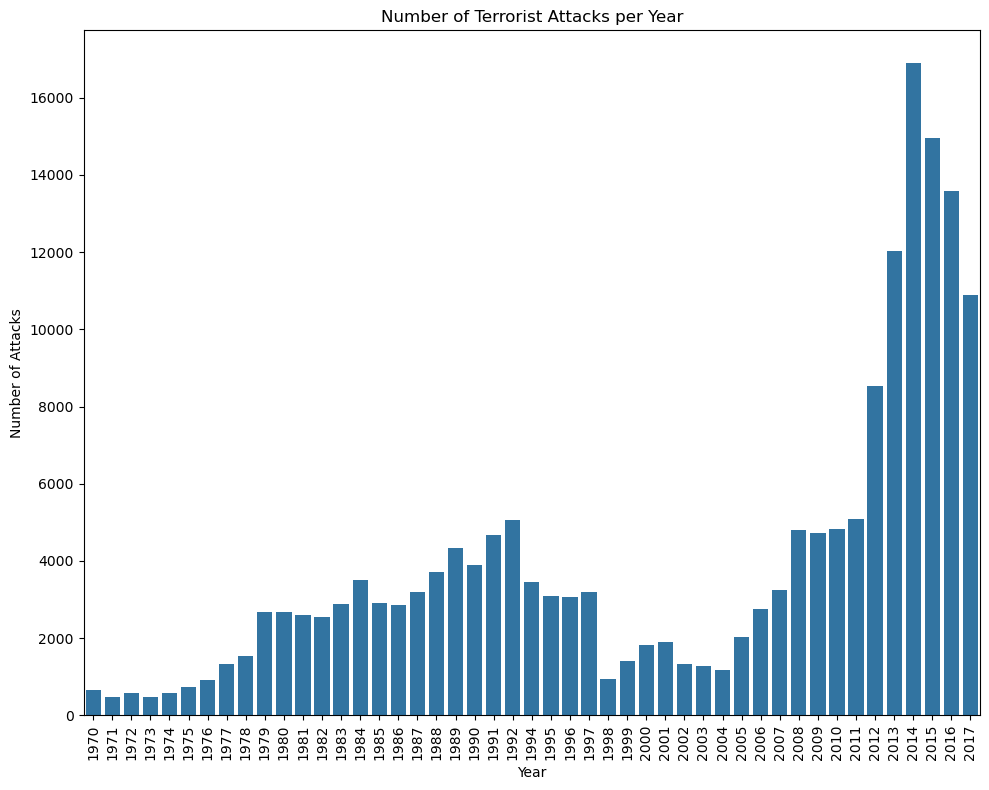

In [230]:
plt.figure(figsize=(10, 8))
sns.countplot(data, x='iyear')
plt.title('Number of Terrorist Attacks per Year')
plt.xlabel('Year')
plt.ylabel('Number of Attacks')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

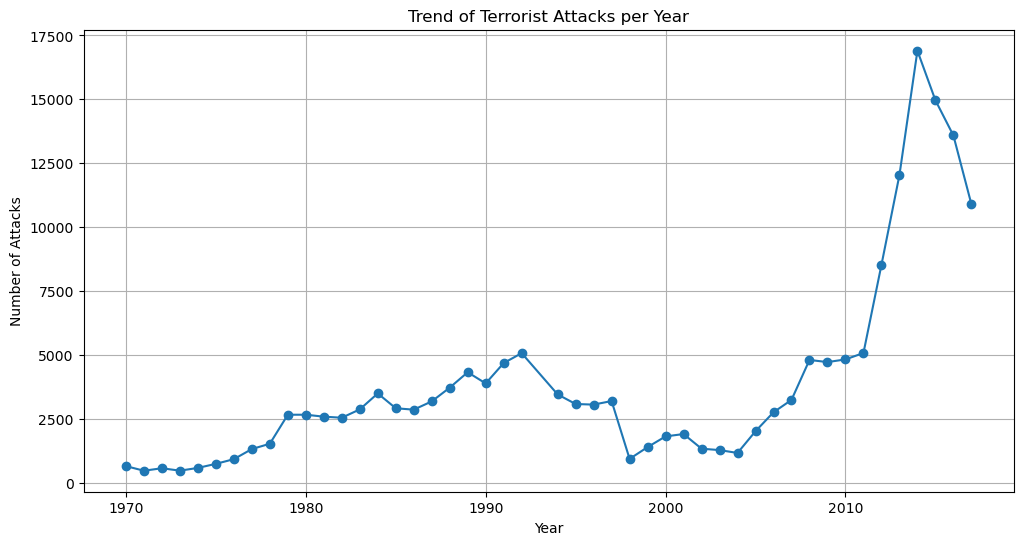

In [231]:
# Trend of Terrorist Attacks every Year
plt.figure(figsize=(12, 6))
plt.plot(attacks_per_year.index, attacks_per_year.values, marker='o', linestyle='-')
plt.title('Trend of Terrorist Attacks per Year')
plt.xlabel('Year')
plt.ylabel('Number of Attacks')
plt.grid(True)
plt.show()

### Different type of Attack Types

In [233]:
attack_types = data['attacktype1_txt'].value_counts().sort_values(ascending=False)
attack_types

attacktype1_txt
Bombing/Explosion                      88255
Armed Assault                          42669
Assassination                          19312
Hostage Taking (Kidnapping)            11158
Facility/Infrastructure Attack         10356
Unknown                                 7276
Unarmed Assault                         1015
Hostage Taking (Barricade Incident)      991
Hijacking                                659
Name: count, dtype: int64

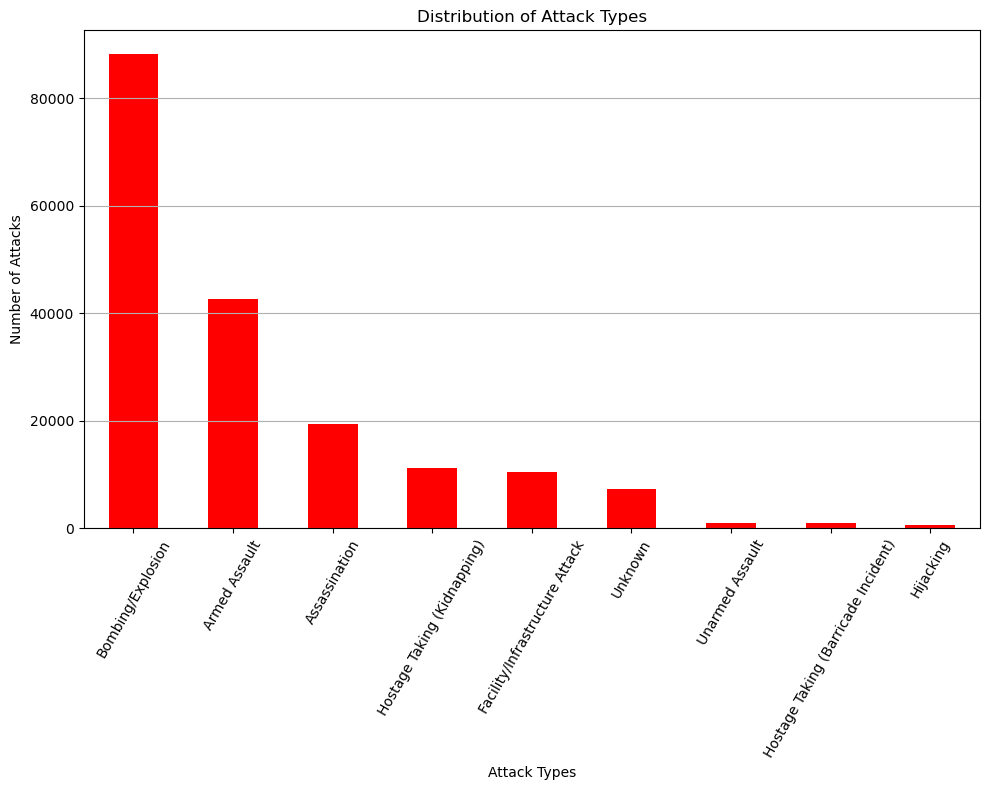

In [234]:
plt.figure(figsize=(10, 8))
attack_types.plot(kind='bar', color='red')
plt.title('Distribution of Attack Types')
plt.xlabel('Attack Types')
plt.ylabel('Number of Attacks')
plt.xticks(rotation=60)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Number of Attacks by Country

In [236]:
attacks_by_country = data['country_txt'].value_counts().sort_values(ascending=False)
attacks_by_country.head(15)

country_txt
Iraq              24636
Pakistan          14368
Afghanistan       12731
India             11960
Colombia           8306
Philippines        6908
Peru               6096
El Salvador        5320
United Kingdom     5235
Turkey             4292
Somalia            4142
Nigeria            3907
Thailand           3849
Yemen              3347
Spain              3249
Name: count, dtype: int64

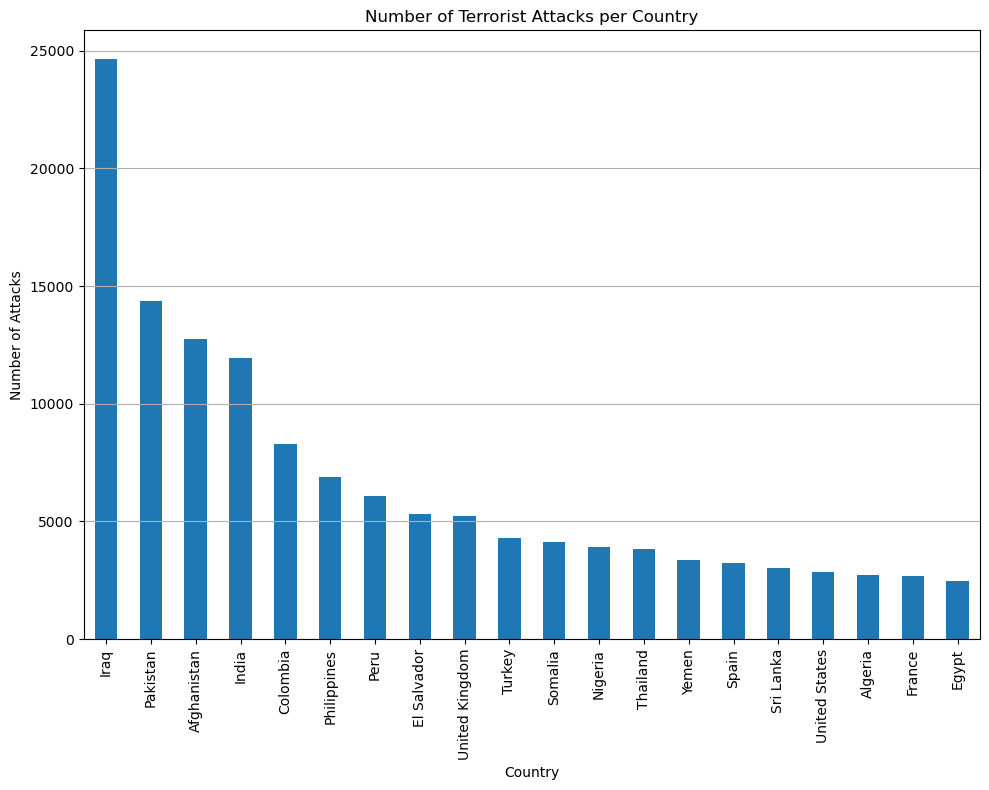

In [237]:
# Number of Terrorist Attacks per country
plt.figure(figsize=(10, 8))
attacks_by_country.head(20).plot(kind='bar')
plt.title('Number of Terrorist Attacks per Country')
plt.xlabel('Country')
plt.ylabel('Number of Attacks')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

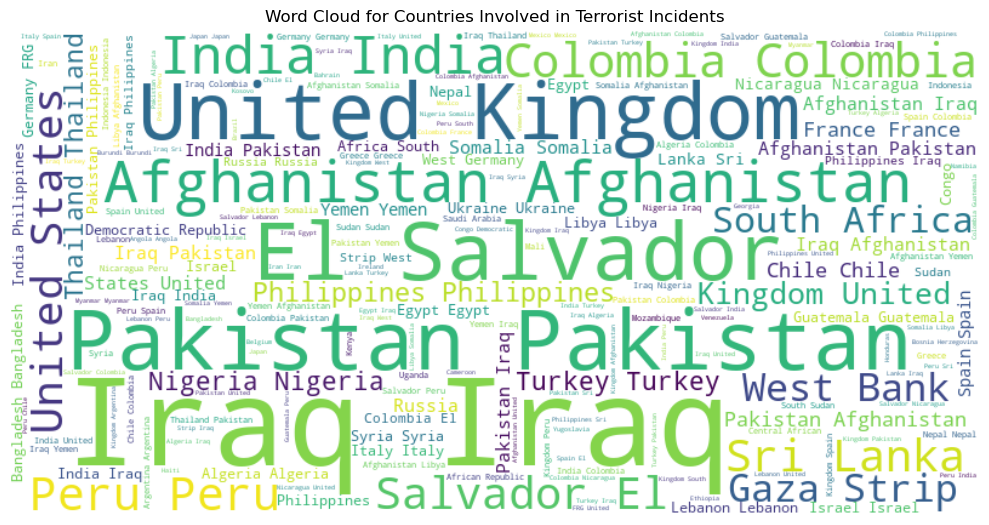

In [238]:
from wordcloud import WordCloud
countries_involved = data['country_txt'].dropna()

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(countries_involved))

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Countries Involved in Terrorist Incidents')
plt.axis('off')
plt.tight_layout()
plt.show()

## Disrtribution of Target Types

In [240]:
target_types = data['targtype1_txt'].value_counts().sort_values(ascending=False)
target_types.head(10)

targtype1_txt
Private Citizens & Property       43511
Military                          27984
Police                            24506
Government (General)              21283
Business                          20669
Transportation                     6799
Utilities                          6023
Unknown                            5898
Religious Figures/Institutions     4440
Educational Institution            4322
Name: count, dtype: int64

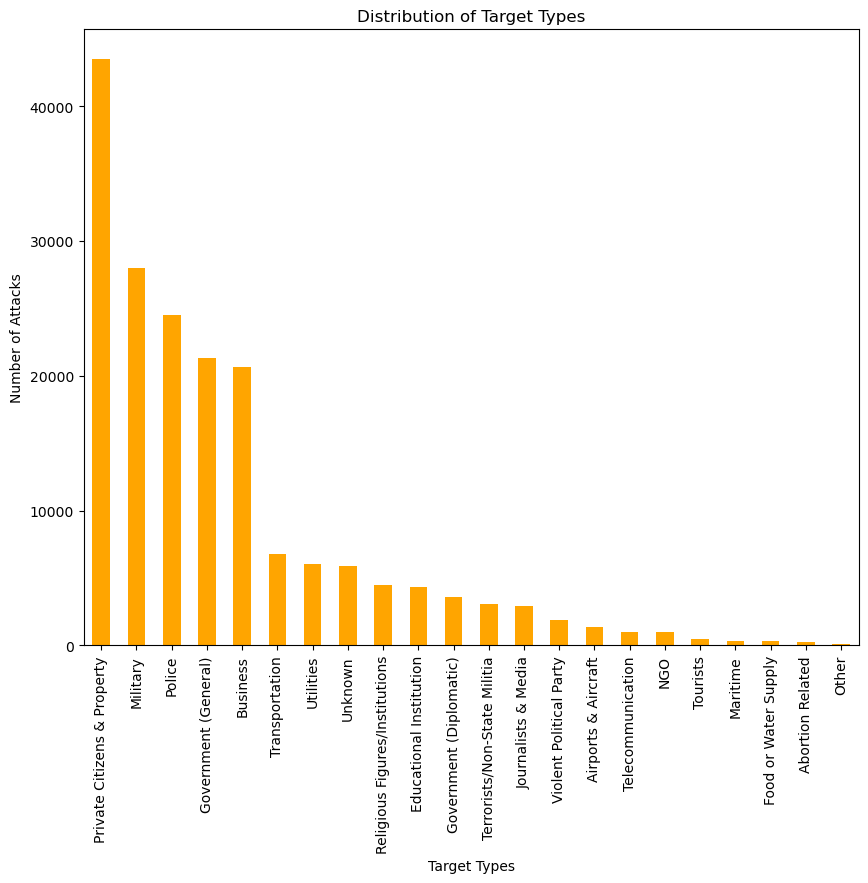

In [241]:
plt.figure(figsize=(10, 8))
target_types.plot(kind='bar', color='orange')
plt.title('Distribution of Target Types')
plt.xlabel('Target Types')
plt.ylabel('Number of Attacks')
plt.xticks(rotation=90)
plt.show()

## Bivariate Analysis

### Number of people killed by Country

In [244]:
casualties_per_year = data.groupby('iyear')['nkill'].count().sort_index()
casualties_per_year

iyear
1970      609
1971      407
1972      524
1973      424
1974      523
1975      587
1976      814
1977     1189
1978     1373
1979     2257
1980     2211
1981     1928
1982     1742
1983     1974
1984     2805
1985     2475
1986     2481
1987     3089
1988     3689
1989     4290
1990     3881
1991     4579
1992     5048
1994     3368
1995     3076
1996     3001
1997     3130
1998      871
1999     1345
2000     1757
2001     1885
2002     1321
2003     1258
2004     1151
2005     1999
2006     2673
2007     3198
2008     4740
2009     4703
2010     4821
2011     5048
2012     8314
2013    11685
2014    15881
2015    14160
2016    12809
2017    10285
Name: nkill, dtype: int64

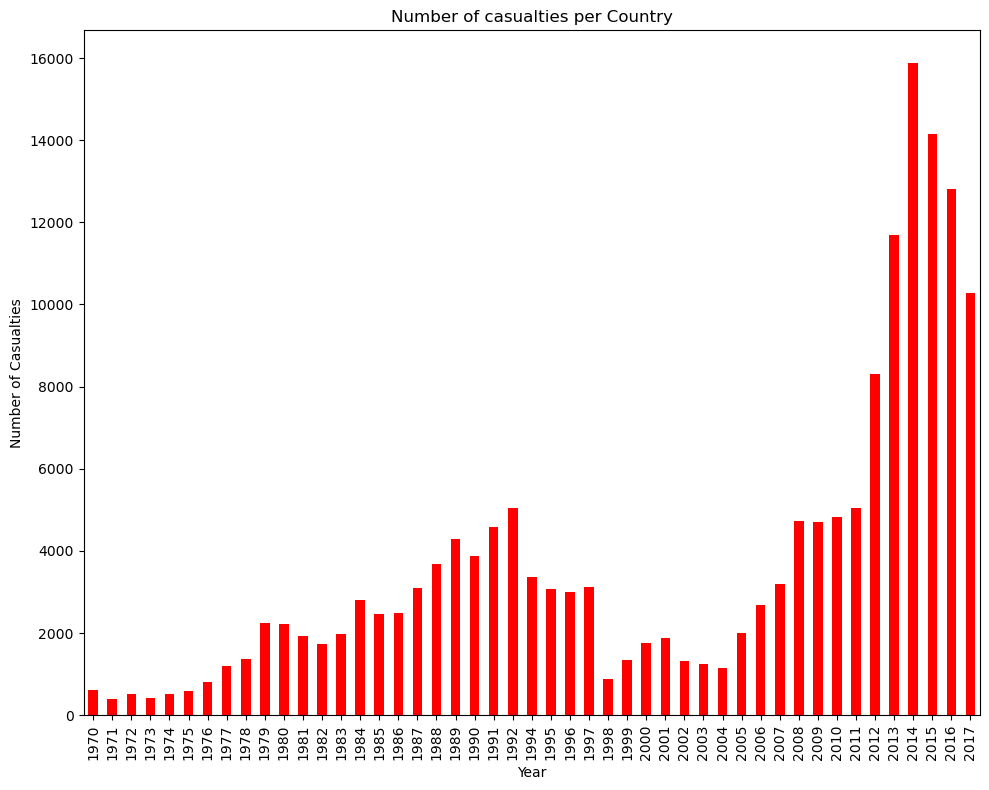

In [245]:
# Number of people killed by country
plt.figure(figsize=(10, 8))
casualties_per_year.plot(kind='bar', color='red')
plt.title('Number of casualties per Country')
plt.xlabel('Year')
plt.ylabel('Number of Casualties')
plt.tight_layout()
plt.show()

### Number of Casualties by Target_types

In [247]:
casualties_by_attackType = data.groupby('attacktype1_txt')['nkill'].sum().sort_values(ascending=False)
casualties_by_attackType

attacktype1_txt
Armed Assault                          160297.0
Bombing/Explosion                      157321.0
Unknown                                 32381.0
Assassination                           24920.0
Hostage Taking (Kidnapping)             24231.0
Hostage Taking (Barricade Incident)      4478.0
Hijacking                                3718.0
Facility/Infrastructure Attack           3642.0
Unarmed Assault                           880.0
Name: nkill, dtype: float64

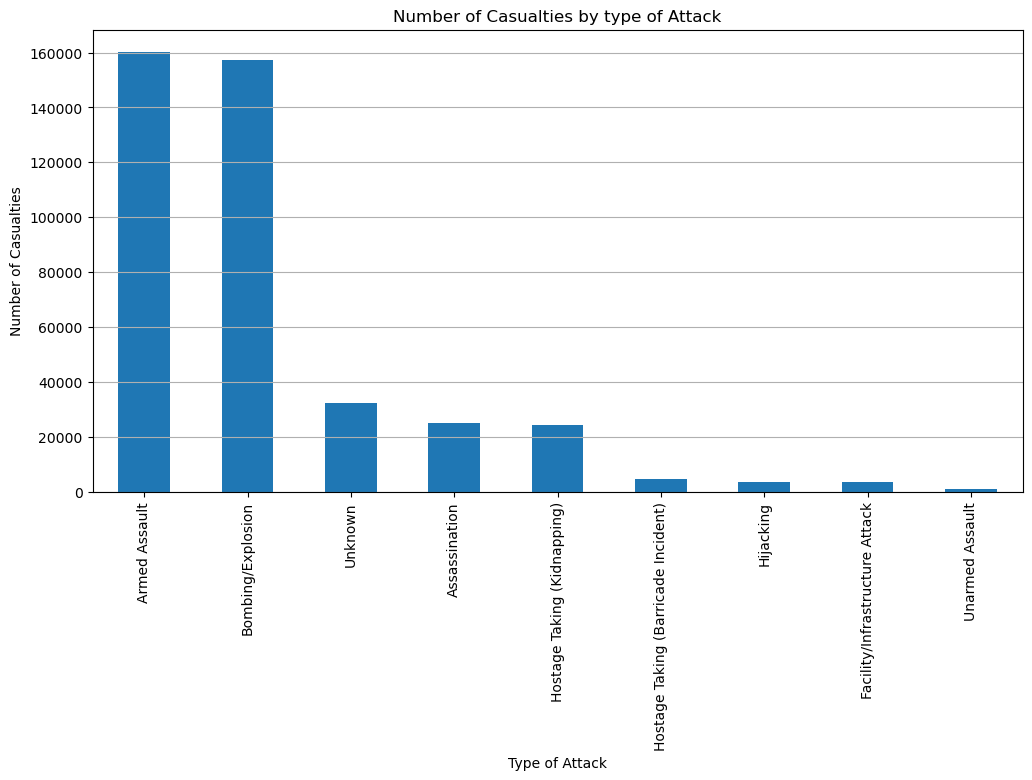

In [248]:
plt.figure(figsize=(12, 6))
casualties_by_attackType.plot(kind='bar')
plt.title('Number of Casualties by type of Attack')
plt.xlabel('Type of Attack')
plt.ylabel('Number of Casualties')
plt.grid(axis='y')
plt.show()

### Top Terrorist Groups by Casualties

In [250]:
top_terrorist_groups = data.groupby('gname')[['nkill', 'nwound']].sum().sort_values(by='nkill', ascending=False)
top_terrorist_groups

,nkill,nwound
gname,,
Unknown,112367.0,210339.0
Islamic State of Iraq and the Levant (ISIL),38923.0,30672.0
Taliban,29410.0,27932.0
Boko Haram,20328.0,9473.0
Shining Path (SL),11601.0,3031.0
...,...,...
New Revolutionary Alternative (NRA),0.0,2.0
Council for the Destruction of Order,0.0,0.0
Counterrevolutionary Solidarity (SC),0.0,0.0


<Figure size 1200x600 with 0 Axes>

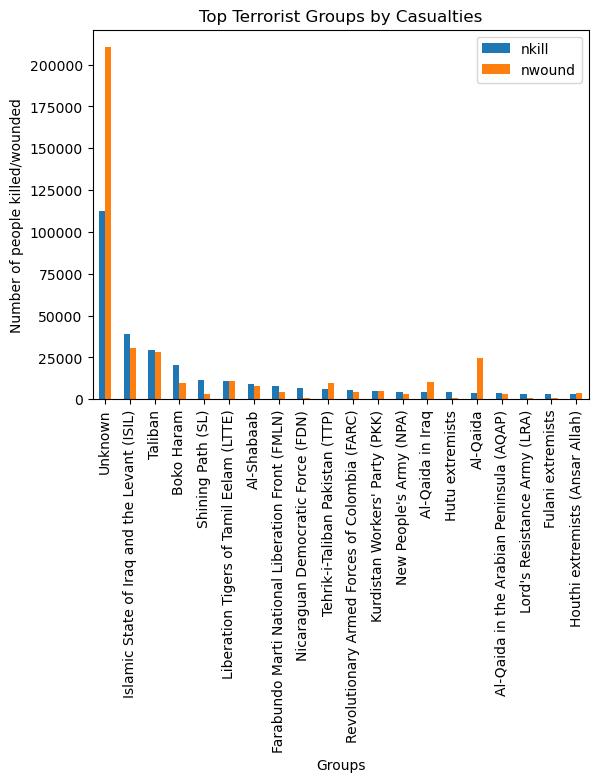

In [251]:
plt.figure(figsize=(12, 6))
top_terrorist_groups.head(20).plot(kind='bar')
plt.title('Top Terrorist Groups by Casualties')
plt.xlabel('Groups')
plt.ylabel('Number of people killed/wounded')
plt.xticks(rotation=90)
plt.legend()
plt.show()

## Summarising EDA

### 1. Top 5 Terrorist Groups (number of Attacks)

In [254]:
groups = data[data['gname'] != 'Unknown']
groups.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
5,197001010002,1970,1,1,NaN,0,NaN,217,United States,1,...,"The Cairo Chief of Police, William Petersen, r...","""Police Chief Quits,"" Washington Post, January...","""Cairo Police Chief Quits; Decries Local 'Mili...","Christopher Hewitt, ""Political Violence and Te...",Hewitt Project,-9,-9,0,-9,NaN
6,197001020001,1970,1,2,NaN,0,NaN,218,Uruguay,3,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
8,197001020003,1970,1,2,NaN,0,NaN,217,United States,1,...,The New Years Gang issue a communiqué to a loc...,"Tom Bates, ""Rads: The 1970 Bombing of the Army...","David Newman, Sandra Sutherland, and Jon Stewa...","The Wisconsin Cartographers' Guild, ""Wisconsin...",Hewitt Project,0,0,0,0,NaN


In [255]:
top_10_terrorist_groups = (data['gname'].value_counts(normalize=True)*100).sort_values(ascending=False)
top_10_terrorist_groups.head(10)

gname
Unknown                                             45.561971
Taliban                                              4.115779
Islamic State of Iraq and the Levant (ISIL)          3.089311
Shining Path (SL)                                    2.507004
Farabundo Marti National Liberation Front (FMLN)     1.844340
Al-Shabaab                                           1.809666
New People's Army (NPA)                              1.525667
Irish Republican Army (IRA)                          1.470078
Revolutionary Armed Forces of Colombia (FARC)        1.368807
Boko Haram                                           1.330831
Name: proportion, dtype: float64

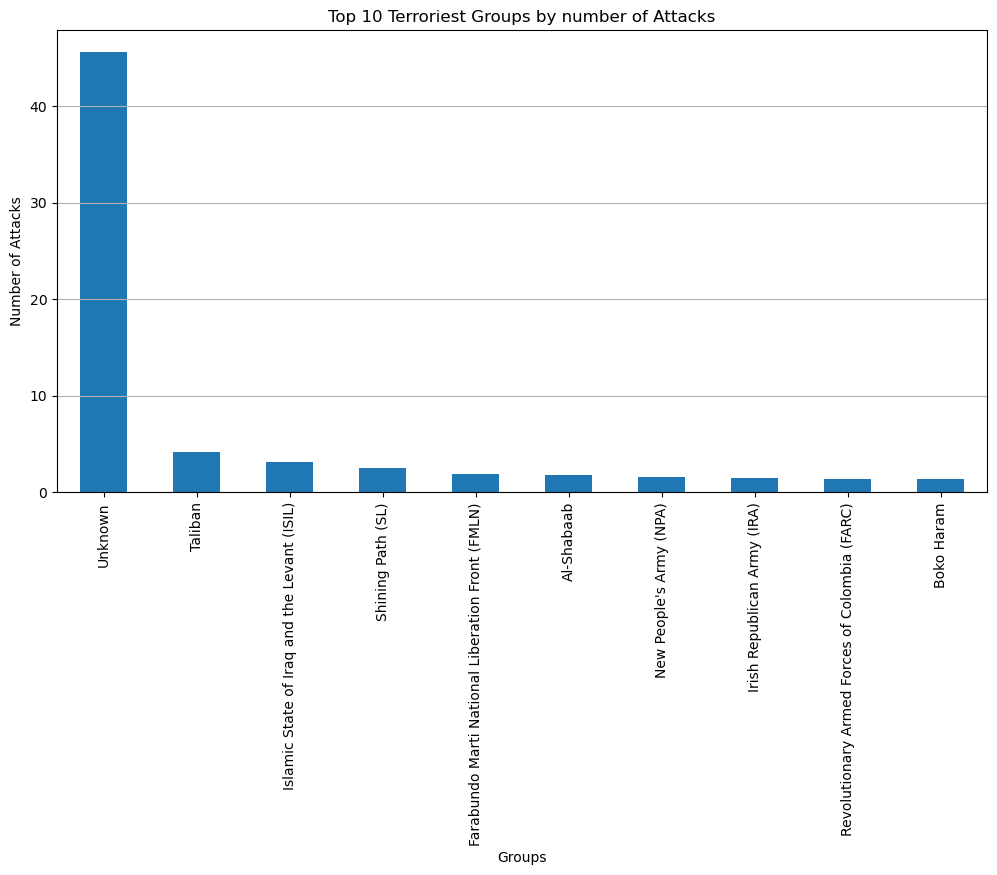

In [256]:
plt.figure(figsize=(12, 6))
top_10_terrorist_groups.head(10).plot(kind='bar')
plt.title('Top 10 Terroriest Groups by number of Attacks')
plt.xlabel('Groups')
plt.ylabel('Number of Attacks')
plt.grid(axis='y')
plt.show()

## 2. Top 10 Countries most affected by Terrorist Attacks

In [258]:
top_10_country = data['country_txt'].value_counts().head(10)
top_10_country

country_txt
Iraq              24636
Pakistan          14368
Afghanistan       12731
India             11960
Colombia           8306
Philippines        6908
Peru               6096
El Salvador        5320
United Kingdom     5235
Turkey             4292
Name: count, dtype: int64

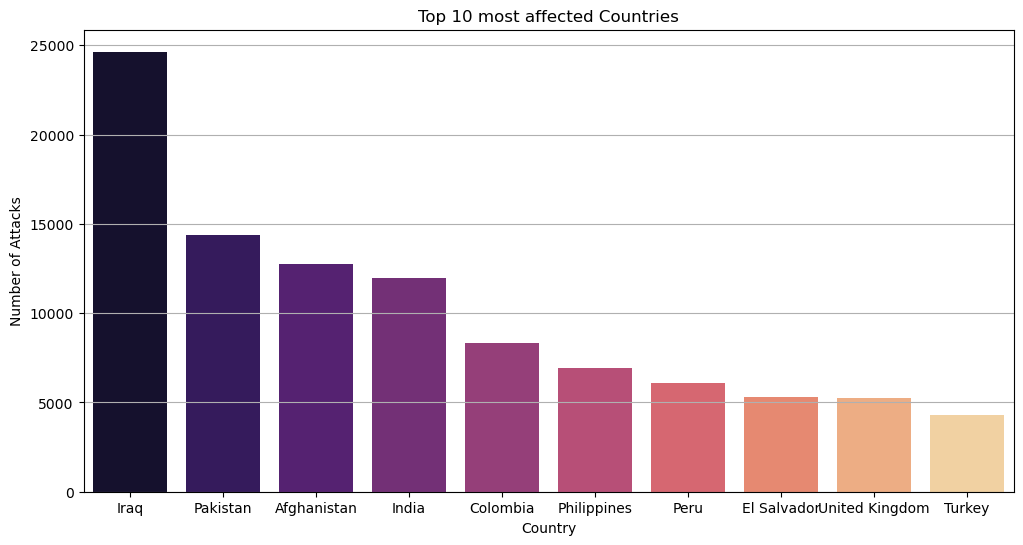

In [259]:
plt.figure(figsize=(12, 6))
# top_10_country.plot(kind='bar')
sns.countplot(data, x='country_txt', order=top_10_country.index, palette='magma')
plt.title('Top 10 most affected Countries')
plt.xlabel('Country')
plt.ylabel('Number of Attacks')
plt.grid(axis='y')
plt.show()

## 3. Top 10 most common attack types

In [261]:
top_10_attack_types = data['attacktype1_txt'].value_counts().head(10)
top_10_attack_types

attacktype1_txt
Bombing/Explosion                      88255
Armed Assault                          42669
Assassination                          19312
Hostage Taking (Kidnapping)            11158
Facility/Infrastructure Attack         10356
Unknown                                 7276
Unarmed Assault                         1015
Hostage Taking (Barricade Incident)      991
Hijacking                                659
Name: count, dtype: int64

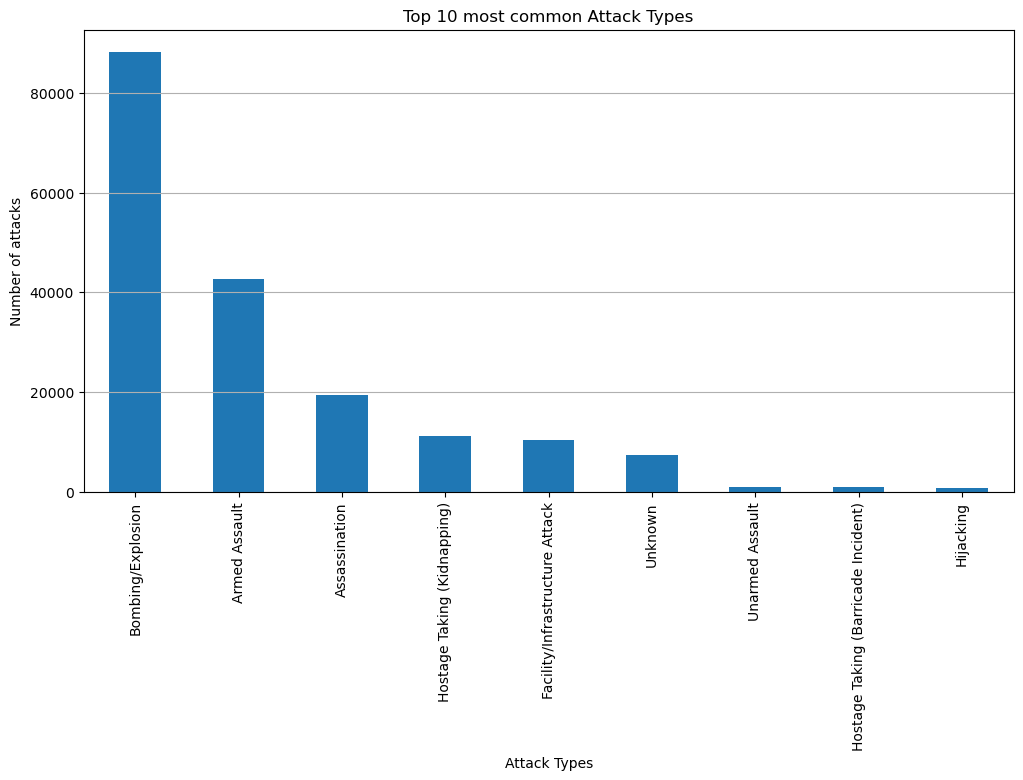

In [262]:
plt.figure(figsize=(12, 6))
top_10_attack_types.plot(kind='bar')
plt.title('Top 10 most common Attack Types')
plt.xlabel('Attack Types')
plt.ylabel('Number of attacks')
plt.grid(axis='y')
plt.show()

## 4. Top 10 most common Target Types

In [264]:
top_10_target_types = data['targtype1_txt'].value_counts().head(10)
top_10_target_types

targtype1_txt
Private Citizens & Property       43511
Military                          27984
Police                            24506
Government (General)              21283
Business                          20669
Transportation                     6799
Utilities                          6023
Unknown                            5898
Religious Figures/Institutions     4440
Educational Institution            4322
Name: count, dtype: int64

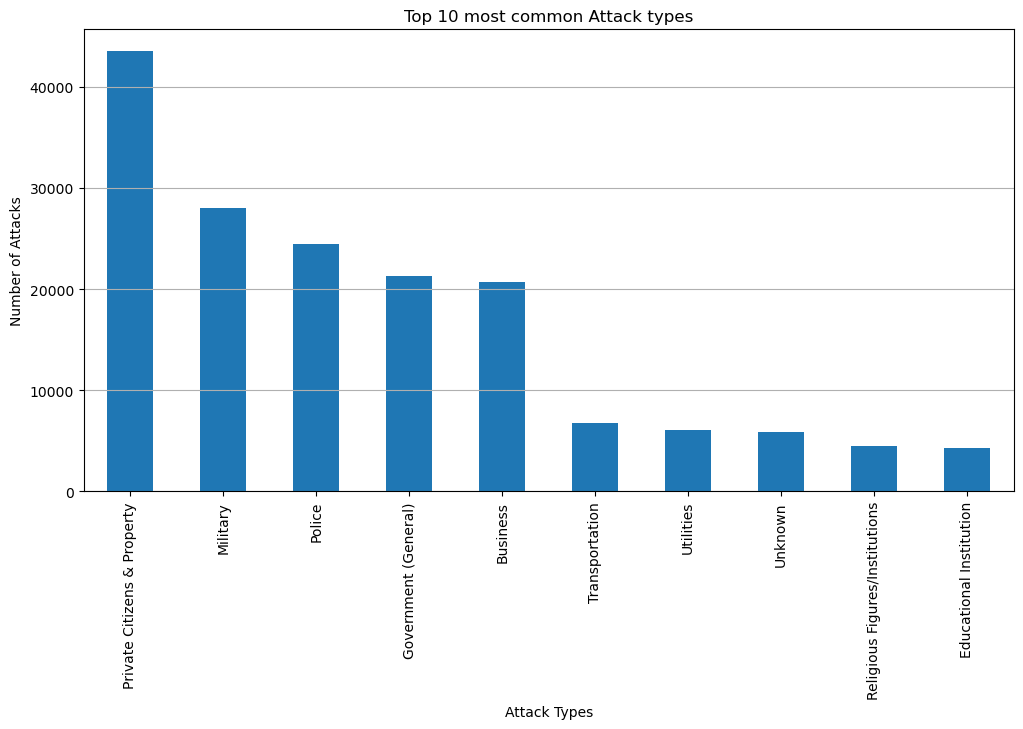

In [265]:
plt.figure(figsize=(12, 6))
top_10_target_types.plot(kind='bar')
plt.title('Top 10 most common Attack types')
plt.xlabel('Attack Types')
plt.ylabel('Number of Attacks')
plt.grid(axis='y')
plt.show()

## 5. Number of Attacks per year

In [267]:
print('Number of Attacks per Year: \n')
print(attacks_per_year)


Number of Attacks per Year: 

iyear
1970      651
1971      471
1972      568
1973      473
1974      581
1975      740
1976      923
1977     1319
1978     1526
1979     2662
1980     2662
1981     2586
1982     2544
1983     2870
1984     3495
1985     2915
1986     2860
1987     3183
1988     3721
1989     4324
1990     3887
1991     4683
1992     5071
1994     3456
1995     3081
1996     3058
1997     3197
1998      934
1999     1395
2000     1814
2001     1906
2002     1333
2003     1278
2004     1166
2005     2017
2006     2758
2007     3242
2008     4805
2009     4721
2010     4826
2011     5076
2012     8522
2013    12036
2014    16903
2015    14965
2016    13587
2017    10900
Name: count, dtype: int64


## 6. Most 10 most affected Regions of the World

In [269]:
top_10_region = data['region_txt'].value_counts().head(10)
top_10_region

region_txt
Middle East & North Africa     50474
South Asia                     44974
South America                  18978
Sub-Saharan Africa             17550
Western Europe                 16639
Southeast Asia                 12485
Central America & Caribbean    10344
Eastern Europe                  5144
North America                   3456
East Asia                        802
Name: count, dtype: int64

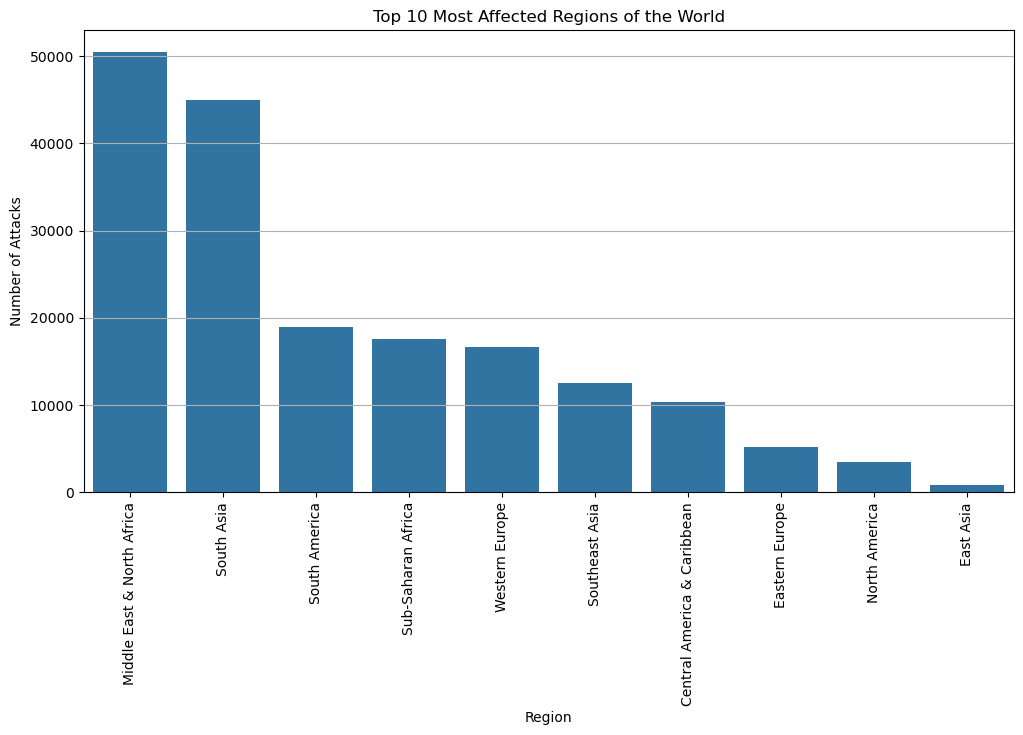

In [270]:
plt.figure(figsize=(12, 6))
# top_10_region.plot(kind='bar')
sns.countplot(data, x='region_txt', order=top_10_region.index)
plt.title('Top 10 Most Affected Regions of the World')
plt.xlabel('Region')
plt.ylabel('Number of Attacks')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()

# Data Preprocessing

### Check for Duplicates

In [273]:
data.duplicated().sum()

0

In [274]:
# No duplicate values

## Null values check

In [276]:
null_values = data.isnull().sum().sort_values(ascending=False)
null_df = pd.DataFrame(null_values, index=None, columns=['Null Count'])

# Null values greater than zero
greater_than_zero = null_df[null_df['Null Count'] > 0]
null_var = len(greater_than_zero)
print(null_var, 'Variables with Null Values')

106 Variables with Null Values


In [277]:
null_df.reset_index(inplace=True)
null_df = null_df.rename(columns={'index': 'Variables'})
null_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Variables   135 non-null    object
 1   Null Count  135 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


In [278]:
null_df[null_df['Null Count']>0]

,Variables,Null Count
0,gsubname3,181671
1,weapsubtype4_txt,181621
2,weapsubtype4,181621
3,weaptype4,181618
4,weaptype4_txt,181618
...,...,...
101,guncertain1,380
102,ishostkid,178
103,specificity,6
104,doubtterr,1


In [279]:
# Calculating percent missing and percent complete
null_df['percent_missing'] = null_df['Null Count']/(len(data))
null_df['percent_complete'] = 1-null_df['percent_missing']

perc_complete = 0.95
selected_attributes = null_df[null_df['percent_complete'] >= perc_complete]
print(len(selected_attributes), f'Attributes have a percent complete >= {int(perc_complete*100)}%')


41 Attributes have a percent complete >= 95%


In [280]:
selected_attributes.reset_index()

,index,Variables,Null Count,percent_missing,percent_complete
0,94,longitude,4557,0.025081,0.974919
1,95,latitude,4556,0.025076,0.974924
2,96,natlty1,1559,0.008581,0.991419
3,97,natlty1_txt,1559,0.008581,0.991419
4,98,target1,638,0.003511,0.996489
5,99,city,435,0.002394,0.997606
6,100,provstate,421,0.002317,0.997683
7,101,guncertain1,380,0.002091,0.997909
8,102,ishostkid,178,0.000980,0.999020
9,103,specificity,6,0.000033,0.999967


In [281]:
selected_attributes_list = selected_attributes['Variables'].to_list()
data_cleaned = data.loc[:, data.columns.isin(selected_attributes_list)]
data_cleaned.shape

(181691, 41)

<Axes: >

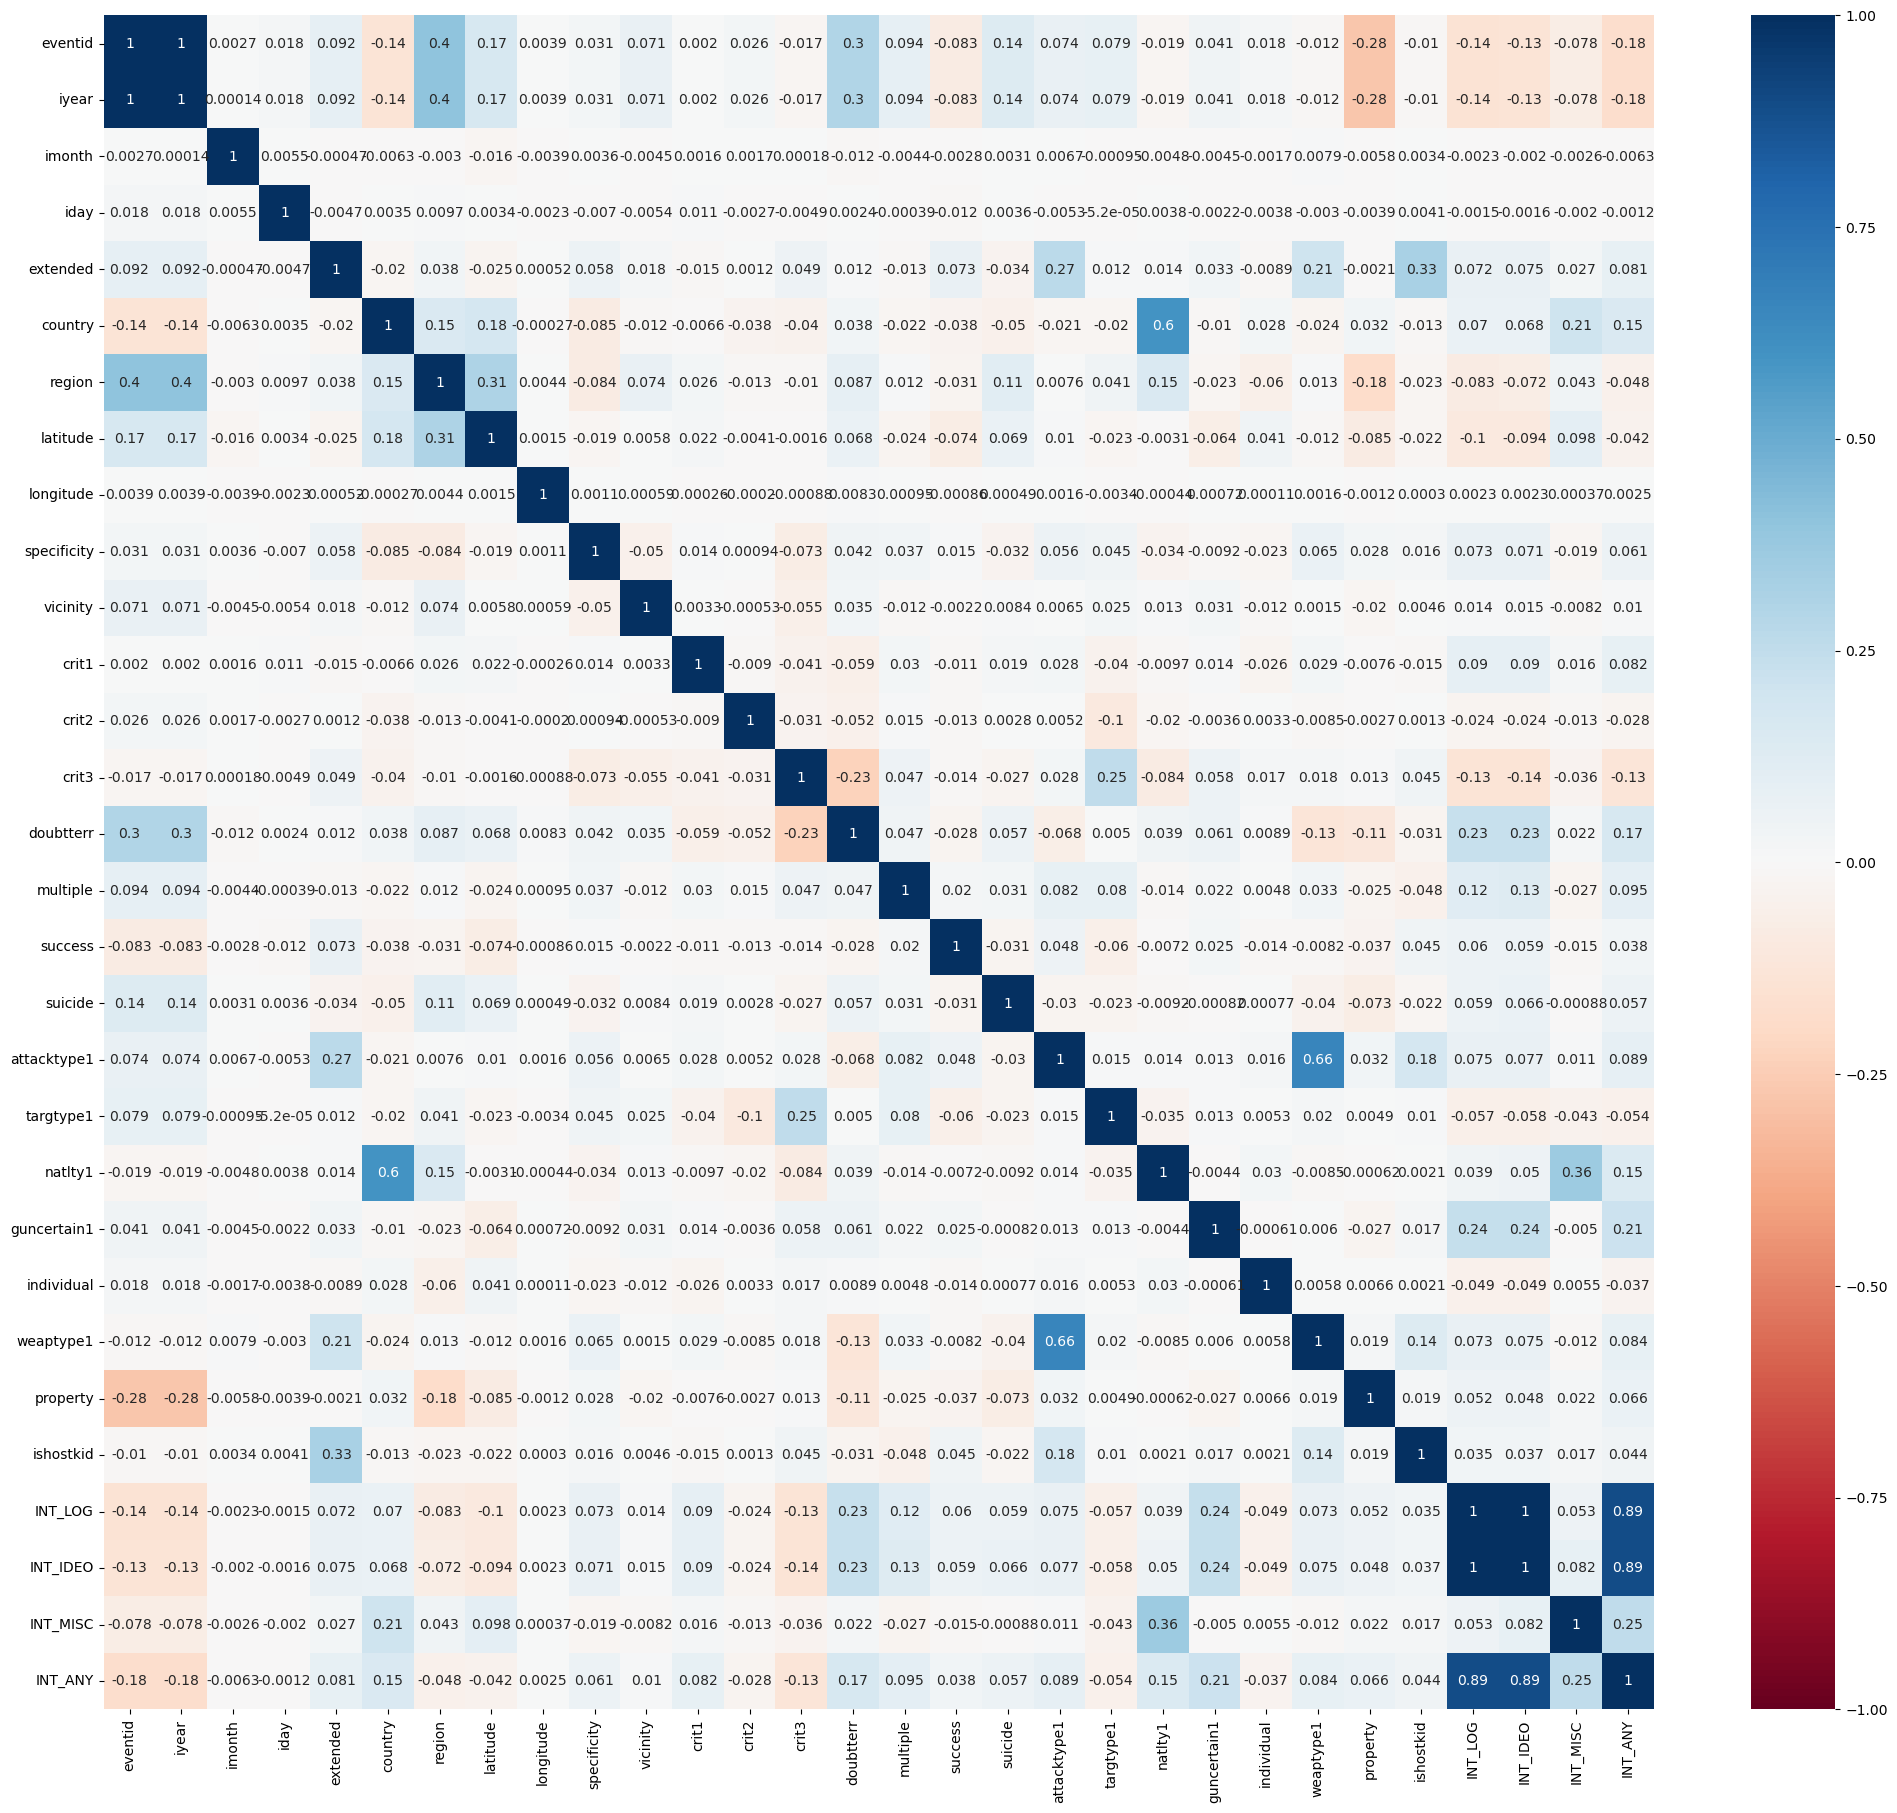

In [282]:
plt.figure(figsize=(25, 22))
sns.heatmap(data_cleaned.corr(numeric_only=True), annot=True, cmap='RdBu', vmin=-1)

In [283]:
corr_matrix = data_cleaned.select_dtypes(np.number).corr()

In [284]:
high_corr = corr_matrix.where((corr_matrix > 0.5) & (corr_matrix < 1.0))

high_corr_pairs = high_corr.stack().reset_index()
high_corr_pairs.columns = ['Feature_1', 'Feature_2', 'Correlation']
high_corr_pairs = high_corr_pairs.sort_values(by='Correlation', ascending=False)

print('Highly correlated feature pairs (0.5 < corr < 1.0)')
print(high_corr_pairs)

Highly correlated feature pairs (0.5 < corr < 1.0)
      Feature_1    Feature_2  Correlation
0       eventid        iyear     0.999996
1         iyear      eventid     0.999996
6       INT_LOG     INT_IDEO     0.996211
8      INT_IDEO      INT_LOG     0.996211
9      INT_IDEO      INT_ANY     0.893811
11      INT_ANY     INT_IDEO     0.893811
7       INT_LOG      INT_ANY     0.891051
10      INT_ANY      INT_LOG     0.891051
3   attacktype1    weaptype1     0.658954
5     weaptype1  attacktype1     0.658954
2       country      natlty1     0.600020
4       natlty1      country     0.600020


In [285]:
# Important - Correlation

In [286]:
corr_df = pd.DataFrame(high_corr_pairs)
corr_df.reset_index(inplace=True)

drop_list = set()

for var1, var2 in zip(corr_df['Feature_1'], corr_df['Feature_1']):
    drop_list.add(var1)
    drop_list.add(var2)

drop_list

{'INT_ANY',
 'INT_IDEO',
 'INT_LOG',
 'attacktype1',
 'country',
 'eventid',
 'iyear',
 'natlty1',
 'weaptype1'}

In [287]:
# Remove correlated columns from the dataset
data_cleaned = data_cleaned.drop(labels=drop_list, axis=1)
data_cleaned.columns

Index(['imonth', 'iday', 'extended', 'country_txt', 'region', 'region_txt',
       'provstate', 'city', 'latitude', 'longitude', 'specificity', 'vicinity',
       'crit1', 'crit2', 'crit3', 'doubtterr', 'multiple', 'success',
       'suicide', 'attacktype1_txt', 'targtype1', 'targtype1_txt', 'target1',
       'natlty1_txt', 'gname', 'guncertain1', 'individual', 'weaptype1_txt',
       'property', 'ishostkid', 'dbsource', 'INT_MISC'],
      dtype='object')

In [288]:
len(data_cleaned.columns)

32

In [289]:
data_cleaned = data_cleaned.drop(labels=['dbsource'], axis=1)

In [290]:
gname_breakdown = data_cleaned.groupby('gname')[['gname']].count().rename(columns={'gname': 'count'})
gname_total = gname_breakdown.index
gname_above_avg = gname_breakdown[gname_breakdown['count'] > gname_breakdown['count'].mean() ]

print('Total Groups: ', len(gname_total))
print('Count of groups responsible for more than the Average attacks: ', len(gname_above_avg))

Total Groups:  3537
Count of groups responsible for more than the Average attacks:  204


In [291]:
# Cut data_cleaned to include only selected groups
gname_above_avg_list = gname_above_avg.index.to_list()
data_cleaned = data_cleaned[data_cleaned['gname'].isin(gname_above_avg_list)]
X_test_final = data_cleaned[data_cleaned['gname']=='Unknown'] # 45% 

In [292]:
# View info on target after removal
gname_breakdown = data_cleaned.groupby(['gname'])[['gname']].count().rename(columns={'gname':'count'})
gname_total = gname_breakdown.index

In [293]:
print('Total groups in new dataset: ', len(gname_total))
print('\n', 'Total number of records after processing: ', len(data_cleaned))

Total groups in new dataset:  204

 Total number of records after processing:  166768


In [294]:
gname_breakdown = data_cleaned.groupby('gname')[['gname']].count().rename(columns={'gname': 'count'})
gname_breakdown

,count
gname,
Abu Sayyaf Group (ASG),527
Action Directe,55
African National Congress (South Africa),607
Al-Aqsa Martyrs Brigade,172
Al-Fatah,56
...,...
United Liberation Front of Assam (ULFA),357
United Popular Action Movement,109
United Self Defense Units of Colombia (AUC),67


In [295]:
# Remove records where gname is 'Unknown'
# Cut data_cleaned 
g_list = gname_breakdown.index.to_list()
g_list.remove('Unknown')

In [296]:
data_cleaned = data_cleaned[data_cleaned['gname'].isin(g_list)]
print("Total number of records after removing 'unknown' groups: ", len(data_cleaned))

Total number of records after removing 'unknown' groups:  83986


## Handle Categorical Variables

In [298]:
# view levels of each categorical variable
    # Only those with levels <30 will be included (ensures python doesn't crash in OneHotEncoding)

cat_vars = data_cleaned.loc[:, data_cleaned.dtypes == object]
cat_vars_count = cat_vars.nunique()
cat_vars_count

country_txt          144
region_txt            12
provstate           1436
city               21912
attacktype1_txt        9
targtype1_txt         22
target1            38862
natlty1_txt          169
gname                203
weaptype1_txt         11
dtype: int64

In [371]:
# For Rest of the Variables like country_txt, weapontype1_txt, natlty1_txt,
# We are going to use Label Encoding.
# Since, There are too many categories in rest of the columns like provstate, city, target1, we are going to drop those columns

In [373]:
data_cleaned = data_cleaned.drop(labels=['provstate', 'city', 'target1'], axis=1)


## Drop records with null values

In [376]:
data_cleaned.isnull().sum()

imonth                0
iday                  0
extended              0
country_txt           0
region                0
region_txt            0
latitude           2723
longitude          2723
specificity           3
vicinity              0
crit1                 0
crit2                 0
crit3                 0
doubtterr             0
multiple              0
success               0
suicide               0
attacktype1_txt       0
targtype1             0
targtype1_txt         0
natlty1_txt         547
gname                 0
guncertain1         374
individual            0
weaptype1_txt         0
property              0
ishostkid            64
INT_MISC              0
dtype: int64

In [378]:
data_cleaned = data_cleaned.dropna()
data_cleaned.shape

(80297, 28)

In [381]:
data_cleaned.columns.values

array(['imonth', 'iday', 'extended', 'country_txt', 'region',
       'region_txt', 'latitude', 'longitude', 'specificity', 'vicinity',
       'crit1', 'crit2', 'crit3', 'doubtterr', 'multiple', 'success',
       'suicide', 'attacktype1_txt', 'targtype1', 'targtype1_txt',
       'natlty1_txt', 'gname', 'guncertain1', 'individual',
       'weaptype1_txt', 'property', 'ishostkid', 'INT_MISC'], dtype=object)

In [383]:
X_test_final.isnull().sum()

imonth                0
iday                  0
extended              0
country_txt           0
region                0
region_txt            0
provstate           230
city                338
latitude           1296
longitude          1297
specificity           2
vicinity              0
crit1                 0
crit2                 0
crit3                 0
doubtterr             1
multiple              0
success               0
suicide               0
attacktype1_txt       0
targtype1             0
targtype1_txt         0
target1             233
natlty1_txt         915
gname                 0
guncertain1           2
individual            0
weaptype1_txt         0
property              0
ishostkid            33
INT_MISC              0
dtype: int64

In [385]:
X_test_final = X_test_final.dropna()
X_test_final = X_test_final.drop(labels=['provstate', 'city', 'target1'], axis=1)
X_test_final.shape

(79830, 28)

In [387]:
X_test_final.head()

,imonth,iday,extended,country_txt,region,region_txt,latitude,longitude,specificity,vicinity,...,targtype1,targtype1_txt,natlty1_txt,gname,guncertain1,individual,weaptype1_txt,property,ishostkid,INT_MISC
2,1,0,0,Philippines,5,Southeast Asia,15.478598,120.599741,4.0,0,...,10,Journalists & Media,United States,Unknown,0.0,0,Unknown,0,0.0,1
3,1,0,0,Greece,8,Western Europe,37.997490,23.762728,1.0,0,...,7,Government (Diplomatic),United States,Unknown,0.0,0,Explosives,1,0.0,1
4,1,0,0,Japan,4,East Asia,33.580412,130.396361,1.0,0,...,7,Government (Diplomatic),United States,Unknown,0.0,0,Incendiary,1,0.0,1
7,1,2,0,United States,1,North America,37.791927,-122.225906,1.0,0,...,21,Utilities,United States,Unknown,0.0,0,Explosives,1,0.0,0
12,1,8,0,Italy,8,Western Europe,41.890961,12.490069,1.0,0,...,6,Airports & Aircraft,United States,Unknown,0.0,0,Firearms,0,0.0,1


In [389]:
from sklearn.preprocessing import OneHotEncoder

In [391]:
encoder = OneHotEncoder
columns = ['region_txt', 'attacktype1_txt', 'targtype1_txt', 'weaptype1_txt'] # cols having categories < 30

In [393]:
df_encoded = pd.get_dummies(data_cleaned, columns=columns, drop_first=True, dtype=int)
df_encoded.shape

(80297, 73)

In [395]:
X_test_encoded = pd.get_dummies(X_test_final, columns=columns, drop_first=True, dtype=int)
X_test_encoded.shape

(79830, 75)

In [397]:
missing_cols = [col for col in X_test_encoded.columns if col not in df_encoded.columns]
print("Columns in X_test_encoded but not in df_encoded:\n", missing_cols)

Columns in X_test_encoded but not in df_encoded:
 ['weaptype1_txt_Chemical', 'weaptype1_txt_Radiological']


In [399]:
X_test_encoded = X_test_encoded.drop(columns=missing_cols)

In [401]:
X_test_encoded.shape

(79830, 73)

In [412]:
# Label Encoding Variables with more than 30 categories (High Cardinality)
# natlty1_txt, country_txt , Since these are relevent columns for prediction

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df_encoded[label_cols] = oe.fit_transform(df_encoded[label_cols].astype(str))
X_test_encoded[label_cols] = oe.transform(X_test_encoded[label_cols].astype(str))

# label_cols = ['country_txt', 'natlty1_txt']
# label_encoders = {}  # to store individual encoders per column

# for col in label_cols:
#     le = LabelEncoder()
#     df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
#     X_test_encoded[col] = le.transform(X_test_encoded[col].astype(str))
#     label_encoders[col] = le  # store for inverse_transform if needed

## Modeling

In [414]:
# Splitting data into independent and dependent variables
x = df_encoded.drop(columns=['gname'])
y = df_encoded['gname']

In [416]:
# Splitting data usingt train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

# Train and Test Shape
print('Training Data: x=%s, y=%s ' % (x_train.shape, y_train.shape))
print('Test Data: x=%s, y=%s' % (x_test.shape, y_test.shape))

Training Data: x=(64237, 72), y=(64237,) 
Test Data: x=(16060, 72), y=(16060,)


## Base Model - LogisticRegression

In [420]:
from sklearn.linear_model import LogisticRegression

In [422]:
model_lr = LogisticRegression()
model_lr.fit(x_train, y_train)

LogisticRegression()

In [424]:
ypred_h_lr = model_lr.predict(x_test)
ypred_s_lr = model_lr.predict_proba(x_test)[:, 1]

In [442]:
accuracy_lr = accuracy_score(y_test, ypred_h_lr)
recall_lr = recall_score(y_test, ypred_h_lr, average='weighted')
precision_lr = precision_score(y_test, ypred_h_lr, average='weighted')

print(f'Accuracy Score LR: {accuracy_lr}')
print(f'Recall Score LR: {recall_lr}')
print(f'Precision Score LR: {precision_lr}')

Accuracy Score LR: 0.6080323785803238
Recall Score LR: 0.6080323785803238
Precision Score LR: 0.47263287160251166


## DecisionTreeClassifier

In [445]:
model_dt = DecisionTreeClassifier(random_state=2)
model_dt.fit(x_train, y_train)

DecisionTreeClassifier(random_state=2)

In [454]:
ypred_h_dt = model_dt.predict(x_test)
ypred_s_dt = model_dt.predict_proba(x_test)[:, 1]

In [458]:
accuracy_dt = accuracy_score(y_test, ypred_h_dt)
recall_dt = recall_score(y_test, ypred_h_dt, average='weighted')
precision_dt = precision_score(y_test, ypred_h_dt, average='weighted')

print(f'Accuracy Score LR: {accuracy_dt}')
print(f'Recall Score LR: {recall_dt}')
print(f'Precision Score LR: {precision_dt}')

Accuracy Score LR: 0.7897260273972603
Recall Score LR: 0.7897260273972603
Precision Score LR: 0.7923790260414186


In [462]:
feature_imp = pd.DataFrame({'importances':model_dt.feature_importances_}, index=x_train.columns.to_list()).sort_values(by='importances', ascending=False)
feature_imp[feature_imp['importances'] > 0].head(12)

,importances
latitude,0.223866
country_txt,0.221140
longitude,0.178011
iday,0.054458
imonth,0.045018
natlty1_txt,0.025794
region_txt_Middle East & North Africa,0.024429
targtype1,0.022837
doubtterr,0.018204
guncertain1,0.014800


In [464]:
print(classification_report(y_test, ypred_h_dt))

                                                              precision    recall  f1-score   support

                                      Abu Sayyaf Group (ASG)       0.84      0.80      0.82       119
                                              Action Directe       0.71      0.56      0.62        18
                    African National Congress (South Africa)       0.96      0.96      0.96       119
                                     Al-Aqsa Martyrs Brigade       0.24      0.35      0.29        31
                                                    Al-Fatah       0.29      0.14      0.19        14
                                Al-Gama'at al-Islamiyya (IG)       0.89      0.85      0.87        39
                                             Al-Nusrah Front       0.59      0.48      0.53        42
                                                    Al-Qaida       0.26      0.33      0.29        15
                                            Al-Qaida in Iraq       0.58      0.58

## RandomForestClassifier

In [467]:
model_rf = RandomForestClassifier(n_estimators=200, random_state=2)
model_rf.fit(x_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=2)

In [490]:
ypred_h_rf = model_rf.predict(x_test)

In [491]:
accuracy_rf = accuracy_score(y_test, ypred_h_rf)
recall_rf = recall_score(y_test, ypred_h_rf, average='weighted')
precision_rf = precision_score(y_test, ypred_h_rf, average='weighted')

print(f'Accuracy Score LR: {accuracy_rf}')
print(f'Recall Score LR: {recall_rf}')
print(f'Precision Score LR: {precision_rf}')

Accuracy Score LR: 0.8309464508094645
Recall Score LR: 0.8309464508094645
Precision Score LR: 0.8220701232031539


In [494]:
# grid_rf = {'n_estimators': [200, 300], 
#            'max_depth': [12, 14], 
#            'min_samples_split': [2, 5],
#            'min_samples_leaf': [1, 2]}

# gscv_rf = GridSearchCV(estimator=RandomForestClassifier(), 
#                        param_grid=grid_rf, 
#                        scoring='accuracy', 
#                        cv=10, 
#                        n_jobs=-1)
# gscv_rf.fit(x_train, y_train)

In [496]:
# best_estimator = gscv_rf.best_estimator_
# best_score = gscv_rf.best_score_
# best_params = gscv_rf.best_params_

# print('Best Score : ', best_score)
# print('Best Params: \n', best_params)

## Creating a Metrics DataFrame for the Models

In [481]:
# Initialize an empty list to collect all model metrics
metrics = []

# Define a helper function to evaluate and store metrics
def evaluate_model(name, y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average='weighted') # weighted: accounts for class imbalance (more realistic for many datasets).
    precision = precision_score(y_true, y_pred, average='weighted') 
    
    metrics.append({
        'Model': name,
        'Accuracy': round(accuracy, 4),
        'Recall': round(recall, 4),
        'Precision': round(precision, 4)
    })

# Assuming you already have the following predictions:
# y_pred_lr        => Logistic Regression predictions
# y_pred_dt        => Decision Tree predictions
# y_pred_rf        => Random Forest predictions
# y_test           => True values

# Evaluate and store metrics
evaluate_model("Logistic Regression", y_test, ypred_h_lr)
evaluate_model("Decision Tree", y_test, ypred_h_dt)
evaluate_model("Random Forest", y_test, ypred_h_rf)

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics)

# Display metrics
print(metrics_df)

                 Model  Accuracy  Recall  Precision
0  Logistic Regression    0.6080  0.6080     0.4726
1        Decision Tree    0.7897  0.7897     0.7924
2        Random Forest    0.8309  0.8309     0.8221


## Predicting Unknown gnames using Test Data

In [509]:
ypred_h_fin = model_rf.predict(X_test_encoded.drop(columns=['gname']))

In [510]:
ypred_h_fin.shape

(79830,)

In [513]:
X_test_encoded['Predicted_gnames'] = ypred_h_fin

## Final predictions on the test data using RandomForestModel

In [517]:
X_test_encoded['Predicted_gnames'].value_counts()

Predicted_gnames
Taliban                                        46547
Islamic State of Iraq and the Levant (ISIL)    14810
Chechen Rebels                                  1544
Separatists                                     1420
Al-Shabaab                                      1385
                                               ...  
Allied Democratic Forces (ADF)                     1
Chukakuha (Middle Core Faction)                    1
Palestine Liberation Organization (PLO)            1
Black September                                    1
Lord's Resistance Army (LRA)                       1
Name: count, Length: 133, dtype: int64